In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
gosp = pd.read_excel("gospodarstwa.xlsx")
gosp.head()

,klm,woj,trb,zut,d21,d32,d345,d347,d348,d36,d38,d61,d63,los,dochg,wydg
0,1,2,11,5,2,1,1,2,1,69,2,3,3,1.0,1191.41,1037.29
1,1,2,6,1,2,1,2,2,1,74,3,4,2,2.0,821.00,887.01
2,1,2,3,1,1,3,1,2,1,83,3,4,1,4.0,6669.87,6792.13
3,1,2,12,5,2,1,3,3,2,44,2,4,1,3.0,1872.59,1806.83
4,1,2,1,5,1,3,1,2,1,110,5,4,2,2.0,1731.44,2795.08


Należy pamiętać o jednej, zasadnicznej kwestii: jeżeli w zbiorze danych są zmienne na skalach słabych (tj. nominalna i porządkowa) ale zapisane jako zmienne numeryczne to python (jak i inne języki programowania czy pakiety statystyczne) nie będzie tego świadomy! Oznacza to, że trzeba wcześniej lub na poziomie formuły zadeklarować, które zmienne są na słabej skali (tzw. zmienne jakościowe).


In [3]:
gosp.shape

(32487, 16)

In [15]:
gosp.dochg.describe()

count    32451.000000
mean      2127.432944
std       1612.543454
min     -21249.110000
25%       1200.000000
50%       1805.150000
75%       2640.305000
max      50151.970000
Name: dochg, dtype: float64

Czy w naszych danych znajdują się wartości brakujace (NA, NULL)

In [12]:
gosp.dochg.isna().value_counts()

False    32451
True        36
Name: dochg, dtype: int64

In [14]:
gosp.loc[gosp.dochg.isna()].head()

,klm,woj,trb,zut,d21,d32,d345,d347,d348,d36,d38,d61,d63,los,dochg,wydg,dochg_na
415,2,4,6,1,2,1,1,4,1,116,3,4,2,NaN,NaN,NaN,True
1765,1,14,1,7,2,1,1,1,2,29,1,3,4,NaN,NaN,NaN,True
1766,1,14,11,5,2,1,1,1,1,38,2,4,1,NaN,NaN,NaN,True
1769,1,14,2,4,2,1,1,1,2,39,2,5,2,NaN,NaN,NaN,True
1775,1,14,11,4,2,1,1,1,2,32,1,3,3,NaN,NaN,NaN,True


Ograniczamy zbiór danych do tych obserwacji, które:


*   w zmiennej `dochg` nie mają wartości brakujacej
*   `dochg` jest większe od 0



In [17]:
gosp_model = gosp.dropna().loc[gosp.dochg > 0]
gosp_model.shape

(32291, 17)

Sprawdźmy czy jest jakaś zależność między zmienną dochg (dochodami), a wydg (wydataki)


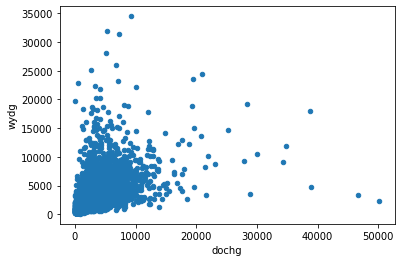

In [18]:
gosp_model.plot.scatter(x = "dochg", y = "wydg")

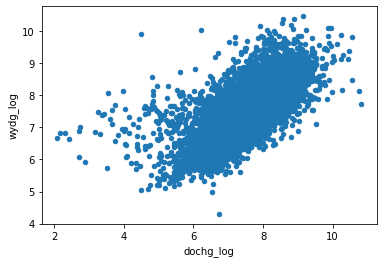

In [19]:
gosp_model["dochg_log"] = np.log(gosp_model.dochg)
gosp_model["wydg_log"] = np.log(gosp_model.wydg)
gosp_model.plot.scatter(x = "dochg_log", y = "wydg_log")

Tworzymy nowe zmienne, które będą miały jednostkę tysiąć złotych, a nie złotówkę.

In [20]:
gosp_model["dochg_tys"] = gosp_model.dochg / 1000
gosp_model["wydg_tys"] = gosp_model.wydg / 1000

W modelu regresji liniowej zakładamy następującą zależnosć:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_k x_k + \epsilon
$$

W pythonie, podobnie jak w R korzysta się z następującej notacji zapisu modelu:

+ `y ~ x` -- symbolem tyldy (`~`) odznaczamy co jest zmienną objaśnianą (`y`), a co jest zmienną objaśniającą (`x`)
+ `y ~ x1 + x2 + x3` -- po symbolu `+` podajemy kolejne zmienne niezależne (objaśniające)

W poniższym przypadku budujemy następujący model regresji liniowej

$$
wydatki = \beta_0 + \beta_1 dochody + \epsilon
$$

In [21]:
## wyłącznie deklaracja modelu!!! Parametry modelu nie są szacowane
model1 = smf.ols(formula = "wydg_tys ~ dochg_tys", data = gosp_model)
model1

In [22]:
## tu dokonuje się szacowanie parametrów modelu -- stosowana jest metoda najmniejszych kwadratów
model1_fit = model1.fit()
model1_fit

In [24]:
## dopiero użycie funkcji summary powoduje pokazanie wyników dla oszacowanego modelu
print(model1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               wydg_tys   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                 2.364e+04
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        14:59:26   Log-Likelihood:                -50277.
No. Observations:               32291   AIC:                         1.006e+05
Df Residuals:                   32289   BIC:                         1.006e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6875      0.011     64.102      0.0

Model na następującą postać:

$$
wydg\_tys = 0.6875 (0.011) + 0.6176 (0.004) \times dochg\_tys 
$$

$$
\hat{\beta}_0 = 0.6875 \;, \hat{\beta}_1 = 0.6176
$$


Interpretacja $\hat{\beta}_1$: jeżeli dochód wzrośnie o jednostkę (o tysiąć złotych) to wydatki wzrosną o 0.6176 jednostki wydatków. Oznacza to, że według tego modelu, każde dodatkowe 1000 złotych skutuje wzrostem wydatków o 618 zł / Z każdego dodatkowego 1000 złotych gospodarstwa wydadzą 618 zł na konsumpcję lub usługi.


Jak to się stało, że logarytmowanie spowodowało, że pojawił się związek liniowy? Można to wytłumaczyć w następujący sposób:

$$
y = \beta_0 X_1^{\beta_1}
$$

zlogarytmujemy obydwie strony

$$
\log(y) = \log\left( \beta_0 X_1^{\beta_1} \right)
$$

to 

$$
\log(y) = \log(\beta_0) + \log\left(X_1^{\beta_1} \right)
$$

to dalej,

$$
\log(y) = \log(\beta_0) + {\beta_1}\log\left(X_1\right)
$$

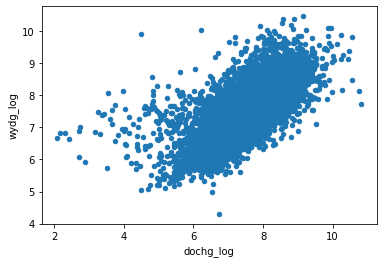

In [25]:
gosp_model.plot.scatter(x = "dochg_log", y = "wydg_log")